## Initial Solution Generation

In [7]:
import gurobipy as gp
import pandas as pd
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans

# Load the data
instance = 'A1'
data = pd.read_excel("Data\Instances\Small_Instances.xlsx", sheet_name=instance)

# customers = data[data['designation'] == 'c']
# KM = KMeans(n_clusters=3, max_iter=500, random_state=42)
# KM.fit(customers[['X', 'Y']])

# data = data[['X', 'Y']]
# data.loc[19] = KM.cluster_centers_[0]
# data.loc[20] = KM.cluster_centers_[1]
# data.loc[21] = KM.cluster_centers_[2]

data

,Number,X,Y,demand,lsp,designation
0,1,47.416821,53.807242,0,1.0,d
1,2,13.439768,8.259892,0,2.0,d
2,3,35.115685,44.278523,0,1.0,s
3,4,17.539752,23.700627,0,2.0,s
4,5,37.094541,19.816419,0,1.0,s
5,6,18.165620,44.401467,0,2.0,s
6,7,21.094196,35.757118,10,2.0,c
7,8,12.744331,39.193129,10,1.0,c
8,9,18.017488,27.315854,10,2.0,c
9,10,29.220487,39.021037,10,1.0,c


Total cost of initial solution: 354.41


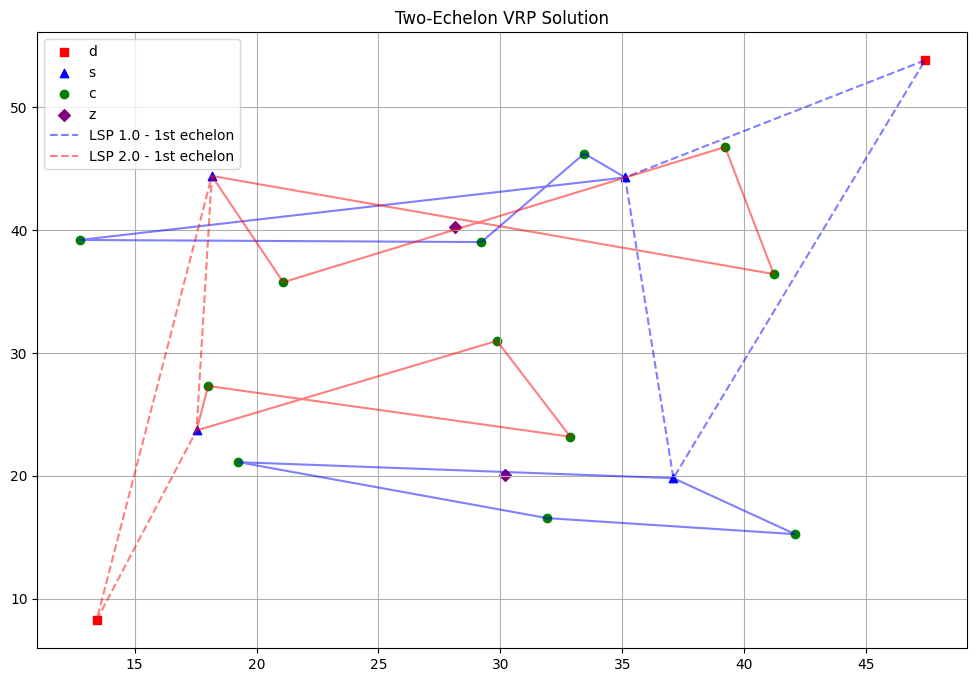

In [10]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Set
from collections import defaultdict

@dataclass(frozen=True)
class Node:
    id: int
    x: float
    y: float
    demand: float
    lsp: int  # service provider
    designation: str  # 'd', 's', 'c', 'z'

@dataclass
class Vehicle:
    id: int
    echelon: int  # 1 or 2
    satellite_id: int  # For 2nd echelon vehicles
    capacity: float
    lsp: int

class InitialSolution:
    def __init__(self, df: pd.DataFrame):
        self.nodes = create_nodes_from_df(df)
        self.lsp_data = self._organize_by_lsp()
        self.vehicles = self._create_vehicles()
        
    def _create_vehicles(self) -> Dict[int, Dict[int, List[Vehicle]]]:
        """
        Create vehicles for each LSP and echelon.
        Returns: Dict[lsp_id, Dict[echelon, List[Vehicle]]]
        """
        vehicles = defaultdict(lambda: defaultdict(list))
        
        for lsp in set(node.lsp for node in self.nodes if node.lsp > 0):  # Exclude collaboration points
            # First echelon: 1 vehicle per LSP
            vehicles[lsp][1] = [
                Vehicle(
                    id=f"{lsp}_1_1",  # format: lsp_echelon_vehicle_number
                    echelon=1,
                    satellite_id=None,
                    capacity=float('inf'),  # Or set specific capacity
                    lsp=lsp
                )
            ]
            
            # Second echelon: 2 vehicles per LSP, one for each satellite
            for i, satellite in enumerate(self.lsp_data[lsp]['satellites'], 1):
                vehicles[lsp][2].append(
                    Vehicle(
                        id=f"{lsp}_2_{i}",
                        echelon=2,
                        satellite_id=satellite.id,
                        capacity=float('inf'),  # Or set specific capacity
                        lsp=lsp
                    )
                )
        
        return vehicles
        
    def _organize_by_lsp(self) -> Dict:
        """Organize nodes by service provider."""
        lsp_data = defaultdict(lambda: defaultdict(list))
        for node in self.nodes:
            if node.designation == 'd':
                lsp_data[node.lsp]['depot'] = node
            elif node.designation == 's':
                lsp_data[node.lsp]['satellites'].append(node)
            elif node.designation == 'c':
                lsp_data[node.lsp]['customers'].append(node)
            elif node.designation == 'z':
                if 'collaboration_points' not in lsp_data[node.lsp]:
                    lsp_data[node.lsp]['collaboration_points'] = []
                lsp_data[node.lsp]['collaboration_points'].append(node)
        return lsp_data
    
    def assign_customers_to_satellites(self, lsp: int) -> Dict[int, List[Node]]:
        """Assign customers to nearest satellites for a given LSP."""
        satellites = self.lsp_data[lsp]['satellites']
        customers = self.lsp_data[lsp]['customers']
        assignments = defaultdict(list)
        
        # Simple nearest satellite assignment
        for customer in customers:
            nearest_satellite = min(
                satellites,
                key=lambda s: calculate_distance(customer, s)
            )
            assignments[nearest_satellite.id].append(customer)
            
        return assignments
    
    def create_first_echelon_routes(self, lsp: int) -> List[Dict]:
        """Create routes from depot to satellites."""
        depot = self.lsp_data[lsp]['depot']
        satellites = self.lsp_data[lsp]['satellites']
        vehicle = self.vehicles[lsp][1][0]  # Single first echelon vehicle
        
        # Create a single route covering all satellites
        route = {
            'vehicle': vehicle,
            'nodes': [depot] + satellites + [depot]
        }
        
        return [route]
    
    def create_second_echelon_routes(self, lsp: int, satellite_assignments: Dict[int, List[Node]]) -> Dict[int, List[Dict]]:
        """Create routes from satellites to customers."""
        routes_by_satellite = {}
        satellites = {s.id: s for s in self.lsp_data[lsp]['satellites']}
        
        # Get second echelon vehicles for this LSP
        vehicles = {v.satellite_id: v for v in self.vehicles[lsp][2]}
        
        for satellite_id, customers in satellite_assignments.items():
            routes = []
            if customers:
                route = {
                    'vehicle': vehicles[satellite_id],
                    'nodes': [satellites[satellite_id]] + customers + [satellites[satellite_id]]
                }
                routes.append(route)
            routes_by_satellite[satellite_id] = routes
            
        return routes_by_satellite
    
    def generate(self) -> Dict:
        """Generate initial solution for all service providers."""
        solution = {}
        
        for lsp in set(node.lsp for node in self.nodes if node.lsp > 0):
            # Step 1: Assign customers to satellites
            satellite_assignments = self.assign_customers_to_satellites(lsp)
            
            # Step 2: Create first echelon routes
            first_echelon_routes = self.create_first_echelon_routes(lsp)
            
            # Step 3: Create second echelon routes
            second_echelon_routes = self.create_second_echelon_routes(lsp, satellite_assignments)
            
            solution[lsp] = {
                'first_echelon_routes': first_echelon_routes,
                'second_echelon_routes': second_echelon_routes
            }
            
        return solution

def calculate_solution_cost(solution: Dict) -> float:
    """Calculate total distance of all routes."""
    total_cost = 0
    
    for lsp_routes in solution.values():
        # First echelon routes
        for route in lsp_routes['first_echelon_routes']:
            nodes = route['nodes']
            for i in range(len(nodes) - 1):
                total_cost += calculate_distance(nodes[i], nodes[i + 1])
        
        # Second echelon routes
        for satellite_routes in lsp_routes['second_echelon_routes'].values():
            for route in satellite_routes:
                nodes = route['nodes']
                for i in range(len(nodes) - 1):
                    total_cost += calculate_distance(nodes[i], nodes[i + 1])
    
    return total_cost

def visualize_solution(df: pd.DataFrame, solution: Dict):
    """Visualize the solution using matplotlib."""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    
    # Plot nodes
    colors = {'d': 'red', 's': 'blue', 'c': 'green', 'z': 'purple'}
    markers = {'d': 's', 's': '^', 'c': 'o', 'z': 'D'}
    
    for designation in ['d', 's', 'c', 'z']:
        mask = df['designation'] == designation
        plt.scatter(df[mask]['X'], df[mask]['Y'], 
                   c=colors[designation], 
                   marker=markers[designation], 
                   label=designation)
    
    # Plot routes with different colors for each LSP
    lsp_colors = {1: 'blue', 2: 'red'}
    
    for lsp, routes in solution.items():
        # First echelon routes
        for route in routes['first_echelon_routes']:
            nodes = route['nodes']
            x = [node.x for node in nodes]
            y = [node.y for node in nodes]
            plt.plot(x, y, '--', color=lsp_colors[lsp], alpha=0.5, 
                    label=f'LSP {lsp} - 1st echelon')
        
        # Second echelon routes
        for satellite_routes in routes['second_echelon_routes'].values():
            for route in satellite_routes:
                nodes = route['nodes']
                x = [node.x for node in nodes]
                y = [node.y for node in nodes]
                plt.plot(x, y, '-', color=lsp_colors[lsp], alpha=0.5)
    
    plt.legend()
    plt.grid(True)
    plt.title('Two-Echelon VRP Solution')
    plt.show()

def create_nodes_from_df(df: pd.DataFrame) -> List[Node]:
    """Convert DataFrame rows to Node objects."""
    nodes = []
    for _, row in df.iterrows():
        nodes.append(Node(
            id=row['Number'],
            x=row['X'],
            y=row['Y'],
            demand=row['demand'],
            lsp=row['lsp'],
            designation=row['designation']
        ))
    return nodes

def calculate_distance(node1: Node, node2: Node) -> float:
    """Calculate Euclidean distance between two nodes."""
    return np.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)


df = data.copy()

# Run solution
solver = InitialSolution(df)
initial_solution = solver.generate()
total_cost = calculate_solution_cost(initial_solution)
print(f"Total cost of initial solution: {total_cost:.2f}")
visualize_solution(df, initial_solution)


## Solution Improvement